# Optimalization Marketing Costs

Kamu berhasil menunjukkan kinerja yang cemerlang selama mengikuti kursus TripleTen. Karena itu, kamu pun ditawarkan kesempatan untuk menjalani program magang di departemen analitik perusahaan Y.Afisha. Nah, tugas pertama yang mereka berikan kepadamu adalah membantu mengoptimalkan anggaran biaya pemasaran. 

Kamu dibekali dengan:
   - Log/catatan server yang memuat data kunjungan ke situs Y.Afisha dari bulan Januari 2017 hingga bulan Desember 2018
   - File dump yang memuat semua pesanan untuk periode tersebut
   - Statistik biaya pemasaran

Tujuan : 

    Merancang metrik untuk pengoptimalan biaya pemasaran pada periode bulan Januari 2017 hingga bulan Desember 2018 berdasarkan data kunjungan ke situs dan semua pesanan.

Kerangka Konsep :
    1. Mempersiapkan Data
    2. Memperbaiki Data
    3. Menganalisis Data
    4. Kesimpulan Umum

## Deskripsi Data

Dataframe `visits` memuat:
   - `Uid` — ID pengguna
   - `Device` — Perangkat Pengguna
   - `Start Ts` — Tanggal dan waktu dimulainya sesi
   - `End Ts` — Tanggal dan waktu dimulainya sesi
   - `Source Id` — ID sumber iklan, sumber yang digunakan pengguna untuk datang ke situs web

Dataframe `order` memuat:
   - `Uid` — ID pengguna yang membuat pesanan
   - `Buy Ts` — Tanggal dan waktu pesanan dibuat
   - `Revenue` — Pendapatan Y.Afisha dari pesanan tersebut

Dataframe `costs` memuat:
   - `source_id` — ID sumber iklan
   - `dt` — Tanggal
   - `costs` — Pengeluaran untuk sumber iklan pada tanggal tersebut

## Inisialisasi Library

import libraries

In [554]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Mengenal Data

Memuat data

In [555]:
visits = pd.read_csv(
    '/datasets/visits_log_us.csv', 
    dtype={'Device': 'category'}, 
    parse_dates=['Start Ts', 'End Ts'])

In [556]:
orders = pd.read_csv('/datasets/orders_log_us.csv')

In [557]:
costs = pd.read_csv('/datasets/costs_us.csv')

### Data Visit

Identifikasi data

In [558]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [559]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Mengecek data duplikat dan data missing

In [560]:
visits.duplicated().sum()

0

In [561]:
report_null_visits = visits.isnull().sum().to_frame()
report_null_visits = report_null_visits.rename(columns={0:'missing_values'})
report_null_visits['% of total'] = (report_null_visits['missing_values'] / visits.shape[0]).round(2)
report_null_visits.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
Device,0,0.0
End Ts,0,0.0
Source Id,0,0.0
Start Ts,0,0.0
Uid,0,0.0


### Data Order

Identifikasi data

In [562]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [563]:
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Mengecek data duplikat dan data missing

In [564]:
orders.duplicated().sum()

0

In [565]:
report_null_orders = orders.isnull().sum().to_frame()
report_null_orders = report_null_orders.rename(columns={0:'missing_values'})
report_null_orders['% of total'] = (report_null_orders['missing_values'] / orders.shape[0]).round(2)
report_null_orders.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
Buy Ts,0,0.0
Revenue,0,0.0
Uid,0,0.0


### Data Cost

Identifikasi data

In [566]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [567]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Mengecek data duplikat dan data missing

In [568]:
costs.duplicated().sum()

0

In [569]:
report_null_costs = costs.isnull().sum().to_frame()
report_null_costs = report_null_costs.rename(columns={0:'missing_values'})
report_null_costs['% of total'] = (report_null_costs['missing_values'] / costs.shape[0]).round(2)
report_null_costs.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
source_id,0,0.0
dt,0,0.0
costs,0,0.0


## Memperbaiki data

Mengubah dan memperbaiki nama kolom

In [570]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [571]:
orders.columns = ['buy_ts', 'revenue', 'uid']

Mengubah tipe data waktu

In [572]:
orders['buy_ts'] = pd.to_datetime(
    orders['buy_ts'], format="%Y-%m-%d %H:%M")

In [573]:
costs['dt'] = pd.to_datetime(costs['dt'])

## Analisis Data

### Produk

Membuat kolom baru sesuai hari, minggu, bulan, dan tahun kejadian.

In [574]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date

Mencari MAU

In [575]:
mau_total_visit = (
    visits.groupby(['session_year', 'session_month'])
    .agg({'uid': 'nunique'})
    .mean()
)
int(mau_total_visit)

23228

Mencari WAU

In [576]:
wau_total_visit = (
    visits.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
    .mean()
)
int(wau_total_visit)

5621

Mencari DAU

In [577]:
dau_total_visit = (
    visits.groupby('session_date')
    .agg({'uid': 'nunique'})
    .mean()
)
int(dau_total_visit)

907

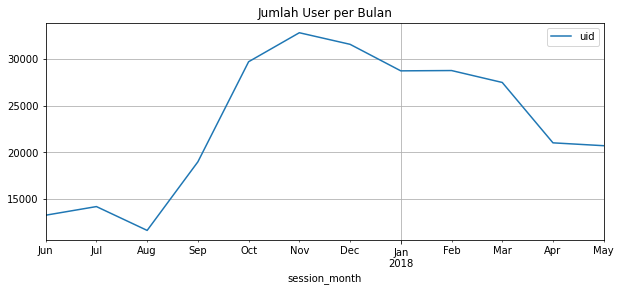

In [578]:
mau_visit = (
    visits.groupby(['session_year', 'session_month'])
    .agg({'uid': 'nunique'})
    .reset_index()
)
mau_visit.plot(x='session_month', y='uid', style='-', title='Jumlah User per Bulan', grid=True, figsize=(10, 4))
plt.show()

Hasil pada grafik menunjukkan bahwa nilai pada bulan November 2017 yang memiliki kunjungan paling banyak

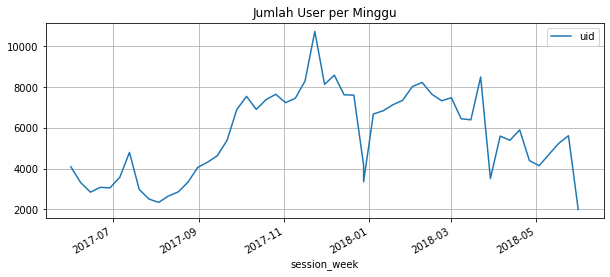

In [579]:
wau_visit = (
    visits.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
    .reset_index()
)
wau_visit.plot(x='session_week', y='uid', style='-', title='Jumlah User per Minggu', grid=True, figsize=(10, 4))
plt.show()

Hasil pada grafik menunjukkan bahwa nilai pada minggu di bulan November 2017 yang memiliki kunjungan paling banyak

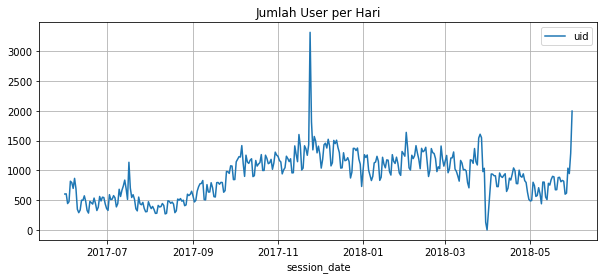

In [580]:
dau_visit = (
    visits.groupby('session_date')
    .agg({'uid': 'nunique'})
    .reset_index()
)
dau_visit.plot(x='session_date', y='uid', style='-', title='Jumlah User per Hari', grid=True, figsize=(10, 4))
plt.show()

Hasil pada grafik menunjukkan bahwa nilai pada hari pada bulan November 2017 yang memiliki kunjungan paling banyak

In [581]:
sticky_wau = dau_total_visit / wau_total_visit * 100
sticky_wau

uid    16.151541
dtype: float64

Jumlah user yang kembali datang di setiap minggu berkisar 16%

In [582]:
sticky_mau = dau_total_visit / mau_total_visit * 100
sticky_mau

uid    3.90897
dtype: float64

Jumlah user yang kembali datang di setiap bulan berkisar 3%

Menghitung sesi per hari pada user unique

In [583]:
sessions_per_user = visits.groupby('session_date').agg(
    {'uid': ['count', 'nunique']}).reset_index()
sessions_per_user.columns = ['session_date', 'n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)
sessions_per_user

,session_date,n_sessions,n_users,sess_per_user
0,2017-06-01,664,605,1.097521
1,2017-06-02,658,608,1.082237
2,2017-06-03,477,445,1.071910
3,2017-06-04,510,476,1.071429
4,2017-06-05,893,820,1.089024
...,...,...,...,...
359,2018-05-27,672,620,1.083871
360,2018-05-28,1156,1039,1.112608
361,2018-05-29,1035,948,1.091772
362,2018-05-30,1410,1289,1.093871


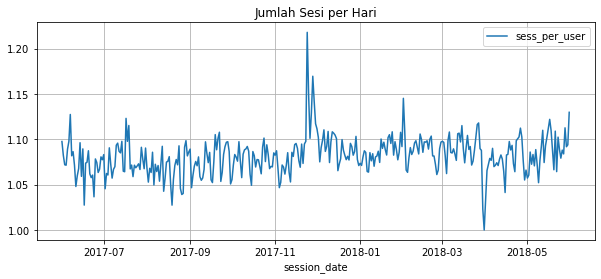

In [584]:
sessions_per_user.plot(x='session_date', y='sess_per_user', style='-', title='Jumlah Sesi per Hari', grid=True, figsize=(10, 4))
plt.show()

Grafik menunjukkan kestabilan di range 1.05 - 1.10, ada sedikit spike ke atas di hari pada bulan November 2017 dan spike ke bawah di hari pada bulan April 2018

Melihat distribusi sesi berdasarkan durasinya

In [585]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [586]:
visits['session_duration_sec']

0         1080
1         1680
2            0
3         1440
4            0
          ... 
359395      19
359396      19
359397      19
359398      19
359399      19
Name: session_duration_sec, Length: 359400, dtype: int64

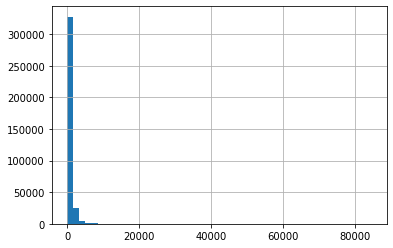

In [587]:
visits['session_duration_sec'].hist(bins=50)
plt.show()

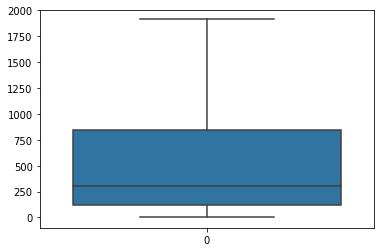

In [588]:
ax = sns.boxplot(data=visits['session_duration_sec'], fliersize=0)
ax.set(ylim=(-100, 2000))
plt.show()

Pada grafik terlihat memiliki persebaran pada range 0 - 2000, dan memiliki median di angka 260.

In [589]:
asl = visits['session_duration_sec'].mode()
asl

0    60
dtype: int64

Nilai ASL memiliki hasil 60

Mencari margin rata-rata pengguna kembali menggunakan produk berdasarkan sesi awal bulan.

In [590]:
first_visits = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visits.columns = ['uid', 'first_session_start_ts']

In [591]:
first_visits['first_session_dt'] = first_visits['first_session_start_ts'].dt.date
first_visits['first_session_month'] = first_visits['first_session_dt'].astype('datetime64[M]')

In [592]:
visits_2 = pd.merge(visits, first_visits, on='uid')

cohort untuk awal bulan

In [593]:
visits_2['first_visits_month'] = (
    visits_2['session_month'] - visits_2['first_session_month']
)
visits_2['first_visits_month'] = visits_2[
    'first_visits_month'
] / np.timedelta64(1, 'M')
visits_2['first_visits_month'] = visits_2['first_visits_month'].astype(int)

In [594]:
cohorts = visits_2.pivot_table(
    index='first_session_month',
    columns='first_visits_month',
    values='uid',
    aggfunc='nunique',
)
cohorts.fillna('')

first_visits_month,0,1,2,3,4,5,6,7,8,9,10
first_session_month,,,,,,,,,,,
2017-06-01,13259.0,,713.0,814.0,909.0,947.0,809.0,766.0,1114.0,539.0,596.0
2017-07-01,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,969.0,,647.0,
2017-08-01,10181.0,783.0,640.0,639.0,510.0,448.0,670.0,284.0,265.0,,
2017-09-01,16704.0,,1712.0,,658.0,1097.0,404.0,381.0,,,
2017-10-01,25977.0,2042.0,1357.0,1012.0,1529.0,555.0,529.0,,,,
2017-11-01,27248.0,,1202.0,1773.0,638.0,594.0,,,,,
2017-12-01,25268.0,1410.0,1570.0,512.0,481.0,,,,,,
2018-01-01,22624.0,2032.0,565.0,458.0,,,,,,,
2018-02-01,22197.0,565.0,446.0,,,,,,,,


Membuat presentasenya

In [595]:
percent_cohort = cohorts.copy()
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    percent_cohort[f'%_{i}'] = round(percent_cohort[i] / percent_cohort[0] * 100, 1)
    if i != 0:
        percent_cohort = percent_cohort.drop([i], axis=1)

percent_cohort = percent_cohort.drop([0], axis=1)
percent_cohort.fillna('')

first_visits_month,%_0,%_1,%_2,%_3,%_4,%_5,%_6,%_7,%_8,%_9,%_10
first_session_month,,,,,,,,,,,
2017-06-01,100.0,,5.4,6.1,6.9,7.1,6.1,5.8,8.4,4.1,4.5
2017-07-01,100.0,5.6,5.1,5.6,5.8,4.8,4.5,7.4,,4.9,
2017-08-01,100.0,7.7,6.3,6.3,5.0,4.4,6.6,2.8,2.6,,
2017-09-01,100.0,,10.2,,3.9,6.6,2.4,2.3,,,
2017-10-01,100.0,7.9,5.2,3.9,5.9,2.1,2.0,,,,
2017-11-01,100.0,,4.4,6.5,2.3,2.2,,,,,
2017-12-01,100.0,5.6,6.2,2.0,1.9,,,,,,
2018-01-01,100.0,9.0,2.5,2.0,,,,,,,
2018-02-01,100.0,2.5,2.0,,,,,,,,


In [596]:
percent_cohort.index = percent_cohort.index.strftime('%Y-%m')

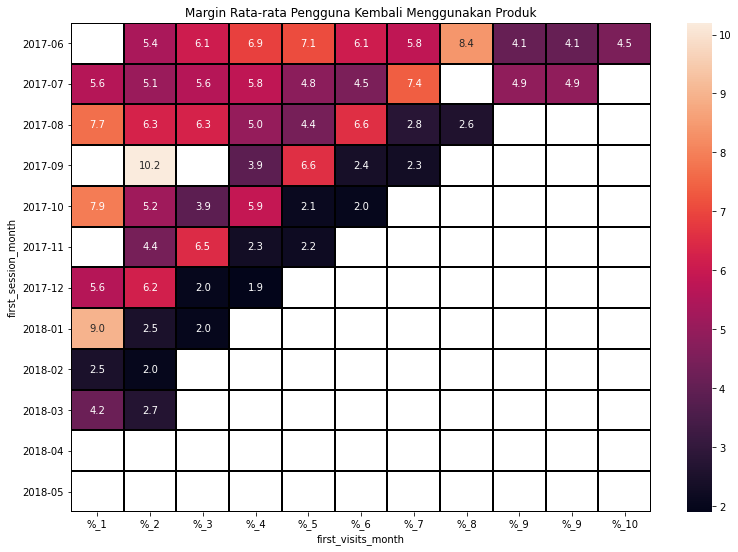

In [597]:
plt.figure(figsize=(13, 9))
plt.title('Margin Rata-rata Pengguna Kembali Menggunakan Produk')
sns.heatmap(
    percent_cohort[['%_1', '%_2', '%_3', '%_4', '%_5', '%_6', '%_7', '%_8', '%_9', '%_9', '%_10']],
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='black',
)
plt.show()

Laporan :
   - Kohort bulan September 2017 yang paling tinggi persentase pengguna untuk kembali pada bulan ke-2.

### Penjualan

Mencari tahu waktu user mulai melakukan pembelian

In [598]:
first_visits.head()

,uid,first_session_start_ts,first_session_dt,first_session_month
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01


In [599]:
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid', 'first_buy']
first_orders

,uid,first_buy
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36518,18445147675727495770,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:55:00
36520,18445601152732270159,2018-03-26 22:54:00
36521,18446156210226471712,2018-02-18 19:34:00


In [600]:
first_orders['first_buy_date'] = first_orders['first_buy'].dt.date
first_orders['first_buy_month'] = first_orders['first_buy'].astype('datetime64[M]')

In [601]:
first_visit_order = first_visits.merge(first_orders, how='inner', on='uid')

Kohort hari user awal transaksi

In [602]:
first_visit_order['first_order_day'] = (
    first_visit_order['first_buy_date'] - first_visit_order['first_session_dt']
)
first_visit_order['first_order_day'] = first_visit_order[
    'first_order_day'
] / np.timedelta64(1, 'D')
first_visit_order['first_order_day'] = first_visit_order['first_order_day'].astype(int)

In [603]:
initial_orders_count = first_visit_order[first_visit_order['first_order_day'] > 0]
initial_orders_count

,uid,first_session_start_ts,first_session_dt,first_session_month,first_buy,first_buy_date,first_buy_month,first_order_day
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-03,2018-01-01,107
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-28,2018-01-01,1
6,3605148382144603,2017-08-15 21:54:00,2017-08-15,2017-08-01,2017-09-21 20:56:00,2017-09-21,2017-09-01,37
10,5081614443770358,2017-10-20 12:10:00,2017-10-20,2017-10-01,2017-11-13 14:43:00,2017-11-13,2017-11-01,24
14,9681021228476518,2017-12-07 23:53:00,2017-12-07,2017-12-01,2017-12-08 01:10:00,2017-12-08,2017-12-01,1
...,...,...,...,...,...,...,...,...
36515,18440933819332658804,2017-10-05 23:03:00,2017-10-05,2017-10-01,2018-01-28 11:22:00,2018-01-28,2018-01-01,115
36516,18442106212931715033,2017-11-27 00:40:00,2017-11-27,2017-11-01,2018-01-06 00:35:00,2018-01-06,2018-01-01,40
36518,18445147675727495770,2017-08-20 13:30:00,2017-08-20,2017-08-01,2017-11-24 09:03:00,2017-11-24,2017-11-01,96
36520,18445601152732270159,2017-08-07 11:51:00,2017-08-07,2017-08-01,2018-03-26 22:54:00,2018-03-26,2018-03-01,231


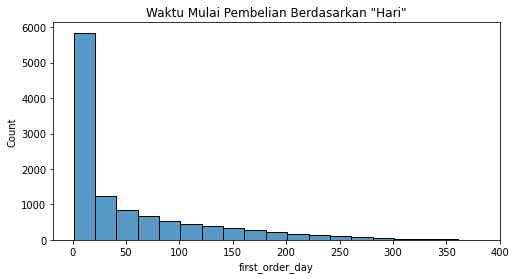

In [604]:
plt.figure(figsize=(8, 4))
plt.title('Waktu Mulai Pembelian Berdasarkan "Hari"')
sns.histplot(initial_orders_count['first_order_day'], binwidth=20)
plt.show()

Pada hari pertama hingga hari ke-25 setelahnya yang memiliki nilai paling tinggi

Mencari jumlah pesanan user selama periode waktu tertentu

In [605]:
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [606]:
monthly_order = orders.groupby('buy_month').agg({'uid': ['nunique', 'count']})['uid'].reset_index()

In [607]:
monthly_order['order_per_user'] = monthly_order['count'] / monthly_order['nunique']
monthly_order = monthly_order.drop(12)
monthly_order

,buy_month,nunique,count,order_per_user
0,2017-06-01,2023,2354,1.163618
1,2017-07-01,1984,2363,1.191028
2,2017-08-01,1472,1807,1.227582
3,2017-09-01,2750,3387,1.231636
4,2017-10-01,4675,5679,1.214759
5,2017-11-01,4547,5659,1.244557
6,2017-12-01,4942,6218,1.258195
7,2018-01-01,3898,4721,1.211134
8,2018-02-01,4258,5281,1.240254
9,2018-03-01,4181,5326,1.273858


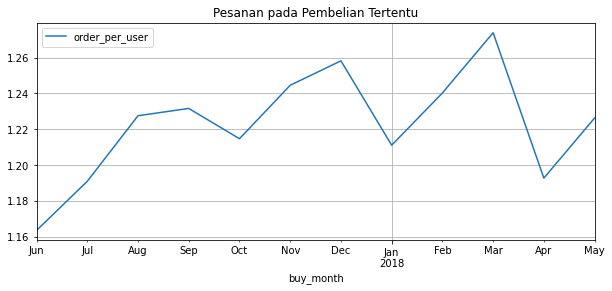

In [608]:
monthly_order.plot(x='buy_month', y='order_per_user', style='-', title='Pesanan pada Pembelian Tertentu', grid=True, figsize=(10, 4))
plt.show()

Terlihat pada grafik menunjukkan hasil yang naik turun dan ini mengindikasikan permintaan yang banyak dari waktu ke waktu

Mencari jumlah besaran rata-rata pembeliannya

In [609]:
revenue_orders_month = orders.groupby('buy_month').agg({'uid': 'nunique', 'revenue': 'mean'})
revenue_orders_month

,uid,revenue
buy_month,,
2017-06-01,2023,4.060106
2017-07-01,1984,5.306589
2017-08-01,1472,4.847139
2017-09-01,2750,5.416448
2017-10-01,4675,4.928280
2017-11-01,4547,4.783518
2017-12-01,4942,5.852139
2018-01-01,3898,4.112927
2018-02-01,4258,4.840095


In [610]:
revenue_orders_month.index = revenue_orders_month.index.strftime('%Y-%m')

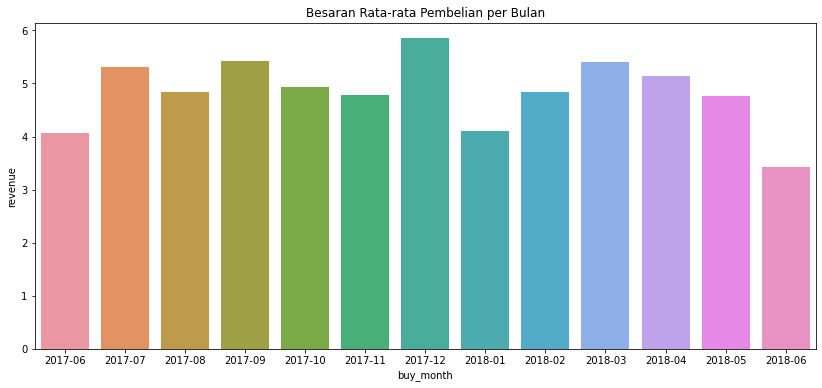

In [611]:
plt.figure(figsize=(14, 6))
sns.barplot(data=revenue_orders_month, y='revenue', x=revenue_orders_month.index)
plt.title('Besaran Rata-rata Pembelian per Bulan')
plt.show()

Pembelian terhadap user yang banyak juga mendatangkan pendapatan yang baik ini mengimplikasikan permintaan yang juga tinggi

Mencari LTV

In [612]:
cohort_sizes = first_orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_buyers']
cohort_sizes.head()

,first_buy_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [613]:
orders_ = pd.merge(orders,first_orders, on='uid')

In [614]:
cohorts = orders_.groupby(['first_buy_month','buy_month']).agg({'revenue': 'sum'}).reset_index()

In [615]:
report = pd.merge(cohort_sizes, cohorts, on='first_buy_month')

margin rate 50%?

In [616]:
margin_rate = 0.5

report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['buy_month'] - report['first_buy_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report.head()

,first_buy_month,n_buyers,buy_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0
1,2017-06-01,2023,2017-07-01,981.82,490.910,1
2,2017-06-01,2023,2017-08-01,885.34,442.670,2
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4


In [617]:
report['ltv'] = report['gp'] / report['n_buyers']

output_ltv = report.pivot_table(
    index='first_buy_month', columns='age', values='ltv', aggfunc='mean'
)

output_ltv.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,2.362207,0.242664,0.218819,0.477336,0.511265,0.367751,0.47522,0.290796,0.276607,0.302894,0.28563,0.128428
2017-07-01,3.005109,0.167605,0.311765,0.179488,0.088396,0.078024,0.060104,0.07091,0.080616,0.073573,0.077837,
2017-08-01,2.638259,0.235996,0.229241,0.195639,0.247026,0.14177,0.105332,0.202504,0.146106,0.093989,,
2017-09-01,2.822265,0.558793,0.260465,1.987896,0.200279,0.323534,0.350804,0.121575,0.092003,,,
2017-10-01,2.501866,0.267881,0.095697,0.078573,0.07578,0.060181,0.042408,0.057735,,,,
2017-11-01,2.577341,0.199617,0.099778,0.162476,0.074006,0.026939,0.057464,,,,,
2017-12-01,2.369095,0.130187,0.462548,0.532637,0.156465,0.169023,,,,,,
2018-01-01,2.067818,0.147379,0.152141,0.071389,0.031349,,,,,,,
2018-02-01,2.078494,0.139137,0.039258,0.037072,,,,,,,,


In [618]:
ltv_201706 = output_ltv.loc['2017-06-01'].sum()
ltv_201706

5.939616905585764

In [619]:
output_ltv.index = output_ltv.index.strftime('%Y-%m')

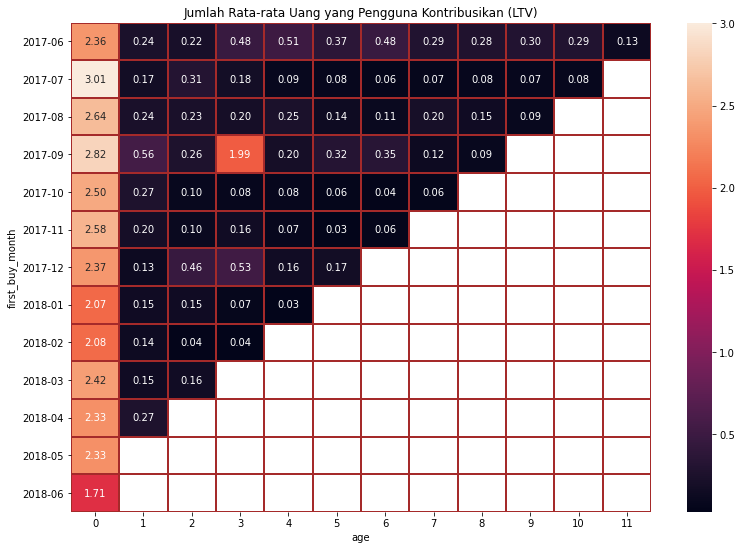

In [620]:
plt.figure(figsize=(13, 9))
plt.title('Jumlah Rata-rata Uang yang Pengguna Kontribusikan (LTV)')
sns.heatmap(
    output_ltv,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='brown',
)
plt.show()

Laporan :
   - Kohort bulan September 2017 yang memiliki nilai paling tinggi pada bulan ke-3 (LTV = 1.99).
   - Secara umum, setiap kohort yang lain masih cukup rendah untuk uang yang di sumbangkan per bulannya.

### Pemasaran

Pemasaran akan kita hitung dari metrik CAC dan ROI

In [621]:
visits['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

In [622]:
report.shape

(79, 7)

In [623]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [624]:
cohort_201706 = report[report['first_buy_month'] == '2017-06-01']

In [625]:
costs_201706 = costs[costs['month'] == '2017-06-01']['costs'].sum()

In [626]:
n_buyers_201706 = cohort_201706['n_buyers'][0]
cac_201706 = costs_201706 / n_buyers_201706 
ltv_201706 = output.loc['2017-06'].sum()

In [627]:
cac_201706

8.905091448344043

Biaya rata-rata yang dikeluarkan perusahaan untuk menarik setiap pelanggan mencapai $8,90

In [628]:
ltv_201706

5.939616905585764

Sementara itu, setiap pelanggan menyumbangkan pendapatan hingga sebesar $5,93

Sekarang menghitung CAC

In [629]:
monthly_costs = costs.groupby('month').sum()
monthly_costs.head()

,source_id,costs
month,,
2017-06-01,1020,18015.00
2017-07-01,1054,18240.59
2017-08-01,1054,14790.54
2017-09-01,1020,24368.91
2017-10-01,1054,36322.88


In [630]:
report_ = pd.merge(report, monthly_costs, left_on='first_buy_month', right_on='month')
report_['cac'] = report_['costs'] / report_['n_buyers']
report_.head()

,first_buy_month,n_buyers,buy_month,revenue,gp,age,ltv,source_id,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0,2.362207,1020,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,490.910,1,0.242664,1020,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,442.670,2,0.218819,1020,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3,0.477336,1020,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4,0.511265,1020,18015.0,8.905091


In [631]:
output_cac = report_.pivot_table(
    index='first_buy_month', columns='age', values='cac', aggfunc='mean'
)

output_cac.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091
2017-07-01,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,
2017-08-01,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,,
2017-09-01,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,,,
2017-10-01,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,,,,
2017-11-01,9.288870,9.28887,9.28887,9.28887,9.28887,9.28887,9.28887,,,,,
2017-12-01,8.741809,8.741809,8.741809,8.741809,8.741809,8.741809,,,,,,
2018-01-01,9.937302,9.937302,9.937302,9.937302,9.937302,,,,,,,
2018-02-01,8.962758,8.962758,8.962758,8.962758,,,,,,,,


In [632]:
output_cac.index = output_cac.index.strftime('%Y-%m')

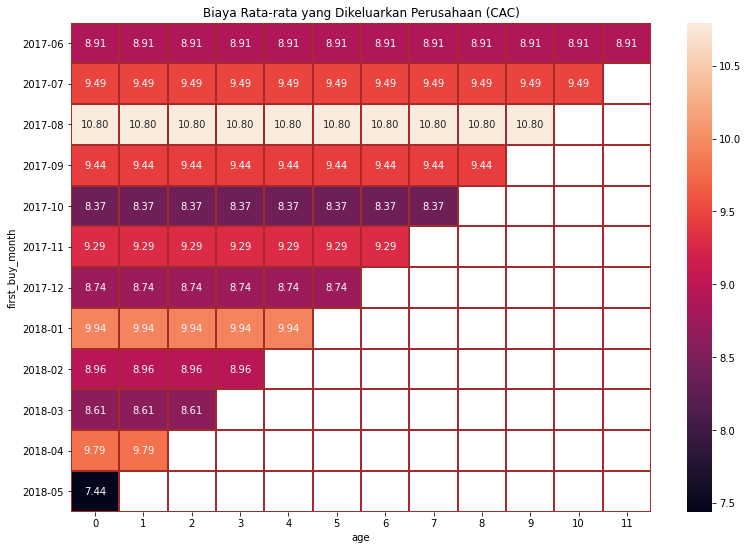

In [633]:
plt.figure(figsize=(13, 9))
plt.title('Biaya Rata-rata yang Dikeluarkan Perusahaan (CAC)')
sns.heatmap(
    output_cac,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='brown',
)
plt.show()

Laporan :
   - Kohort bulan Oktober 2017 yang paling rendah pengeluaran biaya akuisisi (CAC = 8.37).
   - Kohort bulan Agustus 2017 yang paling tinggi pengeluaran biaya akuisisi (CAC = 10.80).
   - Secara umum, setiap kohort yang lain tidak terlalu jauh berbeda nilainya.

Menghitung ROI

In [634]:
report_['roi'] = report_['ltv'] / report_['cac']
output_roi = report_.pivot_table(
    index='first_buy_month', columns='age', values='roi', aggfunc='mean'
)

output_roi = output_roi.cumsum(axis=1).round(2)
output_roi.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.27,0.29,0.32,0.37,0.43,0.47,0.52,0.56,0.59,0.62,0.65,0.67
2017-07-01,0.32,0.33,0.37,0.39,0.4,0.4,0.41,0.42,0.43,0.43,0.44,
2017-08-01,0.24,0.27,0.29,0.31,0.33,0.34,0.35,0.37,0.38,0.39,,
2017-09-01,0.30,0.36,0.39,0.6,0.62,0.65,0.69,0.7,0.71,,,
2017-10-01,0.30,0.33,0.34,0.35,0.36,0.37,0.37,0.38,,,,
2017-11-01,0.28,0.3,0.31,0.33,0.34,0.34,0.34,,,,,
2017-12-01,0.27,0.29,0.34,0.4,0.42,0.44,,,,,,
2018-01-01,0.21,0.22,0.24,0.25,0.25,,,,,,,
2018-02-01,0.23,0.25,0.25,0.26,,,,,,,,


In [635]:
output_roi.index = output_roi.index.strftime('%Y-%m')

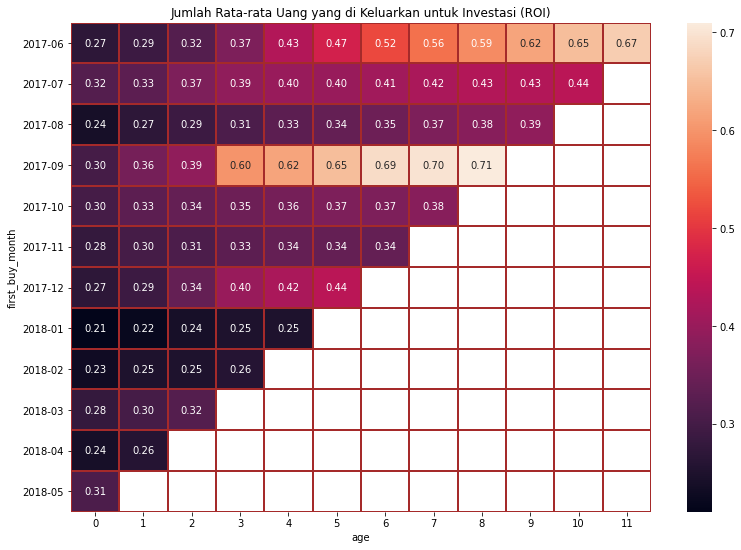

In [636]:
plt.figure(figsize=(13, 9))
plt.title('Jumlah Rata-rata Uang yang di Keluarkan untuk Investasi (ROI)')
sns.heatmap(
    output_roi,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='brown',
)
plt.show()

Laporan :
   - Kohort bulan September 2017 yang paling mendekati biaya return mulai pada bulan ke-3 sampai ke-8 (ROI = 0.6-0,71).
   - Kohort bulan Januari 2018 yang masih paling jauh untuk biaya return investment (ROI = 0,21-0,25).
   - Secara umum, kohort Juni dan September 2017 yang memiliki nilai paling tinggi, setiap kohort yang lain masih jauh untuk menutupi biaya modal secara penuh atau setidaknya mendekati penuh.

## Kesimpulan Umum

Menunggu revisi..